In [1]:
import os
import sys
import csv
import json
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
RED = '\033[31m'
GREEN = '\033[32m'
YELLOW = '\033[33m'
BLUE = '\033[34m'
MAGENTA = '\033[35m'
CYAN = '\033[36m'
WHITE = '\033[37m'
RESET = '\033[0m'

In [3]:
def find_optimal_tiresias(input_dict, xlabel_dict, min_key = None):
    # Step 1: 找到所有包含"Te"的key
    ret_dict = dict()
    
    if not min_key:
        min_value = float("inf")
        for k,v in input_dict.items():
            if 'tiresias' in k:
                if v < min_value:
                    min_key = k
            
    print("Tiresias min schedule: %s" % min_key)   
    ret_dict['Tiresias'] = input_dict[min_key]

    for k,v in input_dict.items():
        if "tiresias" not in k:
            ret_dict[xlabel_dict[k]] = v
        
    return ret_dict, min_key

In [4]:
def get_all_subdirectory_names(directory):
    subdirectory_names = []
    # 使用 os.walk 递归遍历目录树
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            #print(dir_name)
            subdirectory_names.append(dir_name)
    
    return subdirectory_names

In [5]:
def get_scale_factor(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        
    for line in lines:
        if "sf =" in line:
            sf = int(line.split("=")[1].strip())
            return sf

In [6]:
def extract_info(s:str)->dict:
    info = dict()
    time_pattern = re.compile(r'Time\[(\d+\.\d+)ms\]')
    id_pattern = re.compile(r'Job\[\s*(\d+)\]')


    info["job_id"] = int(re.findall("\[(.*?)\]",s,re.I|re.M)[1])
    info["time"] = float(re.findall("\[(.*?)\]",s,re.I|re.M)[0].split()[0])
    info["event"] = s.split(",")[1].strip()

    return info

<>:7: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_3583761/1090345796.py:7: SyntaxWarning: invalid escape sequence '\['
  info["job_id"] = int(re.findall("\[(.*?)\]",s,re.I|re.M)[1])
/tmp/ipykernel_3583761/1090345796.py:8: SyntaxWarning: invalid escape sequence '\['
  info["time"] = float(re.findall("\[(.*?)\]",s,re.I|re.M)[0].split()[0])


In [7]:
def get_job_num(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    
    lines = [extract_info(line) for line in lines if line.startswith("DEBUG")]
    return int(len(lines) / 3) , lines

In [8]:
def get_job_event_time(job_id:int,event:str,lines:list,scale_factor):
    for line in lines:
        if line["job_id"] == job_id and line["event"] == event:
            return float(line["time"]) * scale_factor / 1000
    return None

In [9]:
def main(sched_name:str, scale_factor):
    filename = os.path.join(sched_name, "ares.csv")
    job_num, lines = get_job_num(filename)
    #print(lines)
    jobs = dict()
    jct_sum = list()
    exec_time_list = list()
    for job_id in range(job_num):
        arrive_time = get_job_event_time(job_id,"ARRIVE",lines,scale_factor)
        #print(arrive_time) 
        place_time  = get_job_event_time(job_id,"START", lines,scale_factor)
        end_time    = get_job_event_time(job_id,"END",   lines,scale_factor)
        jobs[job_id] = {
            "arrive_time":arrive_time,
            "place_time":place_time,
            "end_time":end_time,
            "pend_time":place_time - arrive_time,
            "exec_time":end_time - place_time
        }
        #print(job_id,"%.2f" % (end_time - arrive_time))
        jct_sum.append(end_time - arrive_time)
        exec_time_list.append(float("%.2f" % (end_time - arrive_time)))
        ave_jct = np.mean(np.array((jct_sum)))
    tmp = [float("%.2f" % i) for i in jct_sum]
    # print("JCT", tmp)
    # print("EXEC", exec_time_list)
    print("*" * 40)
    print(f"{YELLOW}Schedule name: %s{RESET}" % sched_name)
    print(f"{GREEN}Ave JCT: %.2f{RESET}" % (sum(jct_sum) / job_num))
    print(f"{GREEN}95%%-th JCT: %.2f{RESET}" % np.percentile(jct_sum, 95))
    print(f"{GREEN}Makespan: %.2f{RESET}" % (float(lines[-1]["time"] - lines[0]["time"]) * scale_factor / 1000))
    return jobs, sum(jct_sum) / job_num, np.percentile(jct_sum, 95), (lines[-1]["time"] - lines[0]["time"])

In [10]:
def prefix_sum(lst, loc):
    sum = 0
    for i in range(len(lst)):
        if i < loc:
            sum += lst[i]
    return sum

In [11]:
def make_tiny_bar_config(dirname, job_num, place_list, scale_factor):
    bar_list = list()
    
    tput_file = os.listdir(dirname)
    
    tput_file = [os.path.join(dirname, filename) for filename in tput_file if filename.split(".")[-1] == "txt" and int(filename.split("-")[1]) in list(range(job_num))]
   
    for file in tput_file:
        with open(file, "r") as f:
            job_id = int(file.split("-")[-2])
            lines = f.readlines()
            tput_list = list()
            height_list = list()
            for line in lines:
                tput_list.append(float(line.split(",")[1]) * scale_factor / 1000)
            for i,line in enumerate(lines):
                bottom = place_list[job_id] + prefix_sum(tput_list, i)
                height = tput_list[i] 
                if max(tput_list) == min(tput_list):
                    color = plt.cm.viridis(1 - (height - min(tput_list)) / min(tput_list))
                else:
                    color = plt.cm.viridis(1 - (height - min(tput_list)) / (max(tput_list) - min(tput_list)))

                bar_list.append({
                    "job_id": job_id,
                    "bottom": bottom,
                    "height":height,
                    "color": color
                })
    return bar_list

****************************************
Schedule name: jaca-tiresias
Ave JCT: 6180.57
95%-th JCT: 14450.73
Makespan: 34884.51
****************************************
Schedule name: jaca-consolidate
Ave JCT: 6584.77
95%-th JCT: 14593.94
Makespan: 35883.95
****************************************
Schedule name: jaca-load_balance
Ave JCT: 6943.57
95%-th JCT: 15925.54
Makespan: 27663.23
****************************************
Schedule name: jaca-gandiva
Ave JCT: 6444.31
95%-th JCT: 14223.87
Makespan: 34628.63
****************************************
Schedule name: jaca-jaca
Ave JCT: 6322.73
95%-th JCT: 13626.07
Makespan: 35075.94


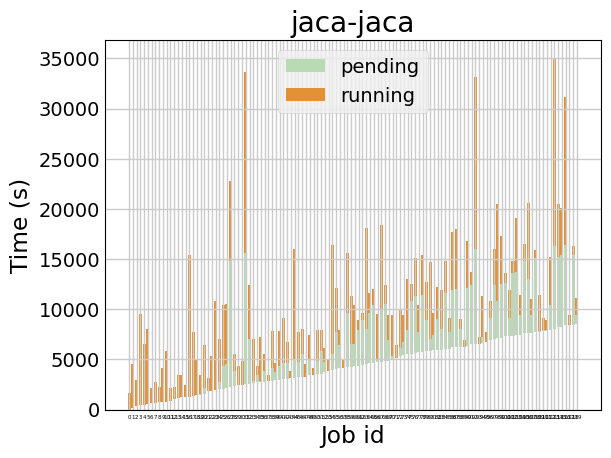

In [12]:
xlabel_dict = {    
    "jaca-load_balance":"K8S",

    "jaca-consolidate":"Yarn", 
    
    "jaca-jaca":"jaca",
    
    "jaca-tiresias":"Tiresias",
    "jaca-gandiva":"Gandiva",
}
sched_list = get_all_subdirectory_names(".")
sched_list = [sched for sched in sched_list if sched in list(xlabel_dict.keys())]
#sched_list = ["jaca-jaca"]
sched_dict = {i:v for i,v in enumerate(sched_list)}
#sched_list = [sched_list[0]]
#print(sched_list)

jct_dict = dict()
jct_dict_95 = dict()
makespan_dict = dict()
scale_factor = get_scale_factor("../../run_interval.py")
for sched in sched_list:
    jobs_info, ave_jct, jct_95, makespan = main(sched,scale_factor)
    jct_dict[sched] = ave_jct
    jct_dict_95[sched] = jct_95
    makespan_dict[sched] = makespan
    #continue
    arrive_list = [v["arrive_time"] for k,v in jobs_info.items()]
    pend_list   = [v["pend_time"]   for k,v in jobs_info.items()]
    exec_list   = [v["exec_time"]   for k,v in jobs_info.items()]
    place_list  = [v["place_time"]  for k,v in jobs_info.items()]
    plt.cla()
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(jobs_info)), pend_list, bottom=arrive_list, color = "#B8DBB3", label = "pending")
    # bar_list = make_tiny_bar_config(sched, len(arrive_list), place_list, scale_factor)
    plt.bar(range(len(jobs_info)), exec_list, bottom=place_list,  color = "#E29135", label = "running")\
    # for bar in bar_list:
    #     plt.bar([bar["job_id"]],[bar["height"]],bottom=[bar["bottom"]],color = bar["color"])
    
    #plt.text(7, 20000, "the deeper color, the slower", fontsize=12, color='red')
    plt.title(sched)
    plt.xticks(range(len(jobs_info)), fontsize=4)
    plt.xlabel("Job id")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.savefig("%s/ares.pdf" % sched, bbox_inches = "tight")

Tiresias min schedule: jaca-tiresias
Tiresias min schedule: jaca-tiresias
Tiresias min schedule: jaca-tiresias


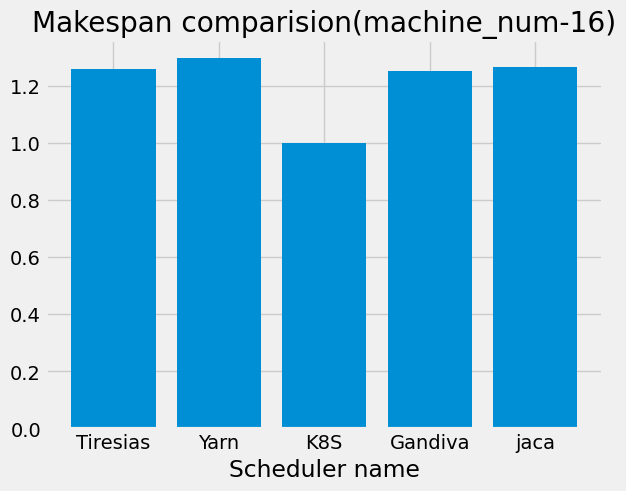

In [13]:
def write_res(filename, info_dict, res_list):
    with open(filename, "w") as f:
        for sched_name, v in zip(list(info_dict.keys()), res_list):
            f.write(f"{sched_name},{v},{info_dict[sched_name]}\n")

#xlabel_dict = {i:xlabel_dict[v] for i,v in enumerate(sched_list)}
dir_name = os.path.realpath(".").split("/")[-1]
final_jct_dict, min_key = find_optimal_tiresias(jct_dict, xlabel_dict)
final_jct_dict_95, min_key = find_optimal_tiresias(jct_dict_95, xlabel_dict, min_key)
final_makespan_dict, min_key = find_optimal_tiresias(makespan_dict, xlabel_dict, min_key)
# JCT
plt.cla()
plt.title(f"JCT comparision({dir_name})")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(final_jct_dict.values())) / min(final_jct_dict.values())
plt.bar(range(len(final_jct_dict)), uniform_value)
plt.xlabel("Scheduler name")
plt.xticks(range(len(final_jct_dict)),list(final_jct_dict.keys()),rotation = 0, fontsize = 14)

write_res("jct.csv", final_jct_dict, uniform_value)
plt.savefig("jct.pdf", bbox_inches = "tight")

# 95th JCT
plt.cla()
plt.title(f"JCT-95th comparision({dir_name})")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(final_jct_dict_95.values())) / min(final_jct_dict_95.values())
plt.bar(range(len(final_jct_dict_95)), uniform_value)
plt.xlabel("Scheduler name")
plt.xticks(range(len(final_jct_dict_95)),list(final_jct_dict_95.keys()),rotation = 0, fontsize = 14)

write_res("jct-95th.csv", final_jct_dict_95, uniform_value)
plt.savefig("jct-95th.pdf", bbox_inches = "tight")

# Makespan
plt.cla()
plt.title(f"Makespan comparision({dir_name})")
plt.style.use("fivethirtyeight")

uniform_value = np.array(list(final_makespan_dict.values())) / min(final_makespan_dict.values())
plt.bar(range(len(final_makespan_dict)), uniform_value)
plt.xlabel("Scheduler name")
plt.xticks(range(len(final_makespan_dict)),list(final_makespan_dict.keys()),rotation = 0, fontsize = 14)

write_res("makespan.csv", final_makespan_dict, uniform_value)
plt.savefig("makespan.pdf", bbox_inches = "tight")